In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/wine-quality-from-chemical-properties/winequality.csv


[Section 1](#section1)

[Section 2](#section2)

[Section 3](#section3)

[Section 4](#section4)

[Section 5](#section5)

Here I use EDA methods on winequality datasets (Section 1). Then I train on it logistic regression classifier, random forest classifier, KNearest neighbors classifier, decision tree classifier and voting classifier (Section 2). Usually voting classifier improves prediction of week classifiers. Then I check if the data reduction will improve predictions. I do it in several ways. At first I use random forest classifiers attribute: feature_importances_ to choose the most important features (Section 3), then I reduce the outliers (Section 4) and at the end I treat data of wine quality with value of 3,4 and 8 as a outliers (Section 5).

The winequality dataset consists of 12 features describing composition of wine, its physical/chemical properties (i.e. pH, density) and its quality.

<a id='section1'>Section 1</a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix

if Version(sklearn_version)<'0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
if Version(sklearn_version)<'0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

df=pd.read_csv('/kaggle/input/wine-quality-from-chemical-properties/winequality.csv')

In [3]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_S_dioxide,total_S_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed_acidity       1599 non-null float64
volatile_acidity    1599 non-null float64
citric_acid         1599 non-null float64
residual_sugar      1599 non-null float64
chlorides           1599 non-null float64
free_S_dioxide      1599 non-null float64
total_S_dioxide     1599 non-null float64
density             1599 non-null float64
pH                  1599 non-null float64
sulphates           1599 non-null float64
alcohol             1599 non-null float64
quality             1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

All data are numerical and there is no non-null values in data set. The datasets consists with little information of wine quality equal 3,4 and 8.

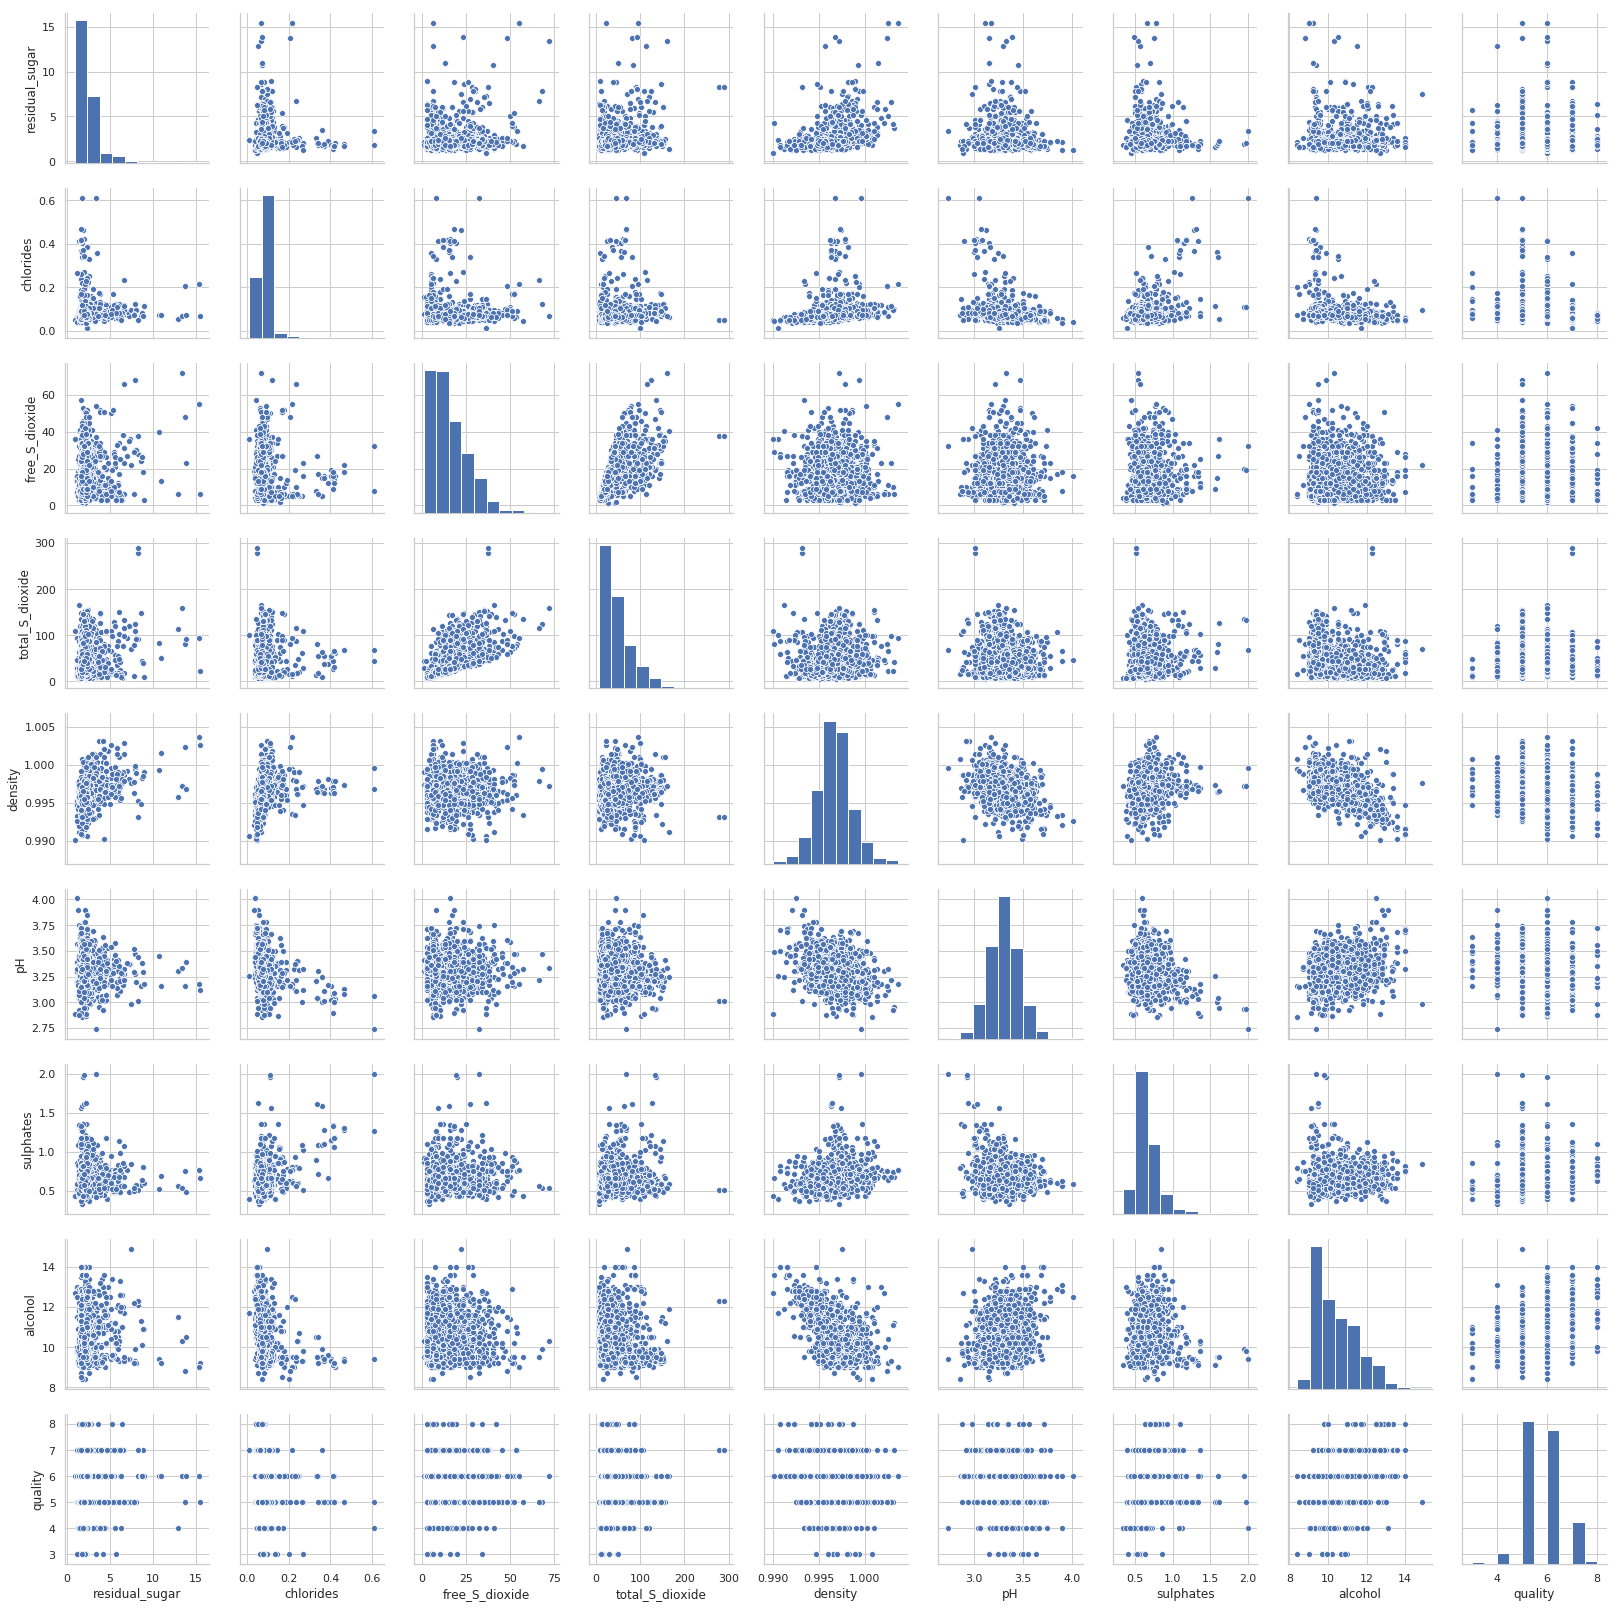

In [6]:
sns.set(style='whitegrid', context='notebook')
cols1=['residual_sugar','chlorides','free_S_dioxide','total_S_dioxide','density','pH','sulphates','alcohol','quality']
sns.pairplot(df[cols1])
plt.show()

Pairplot shows that there is no clear, linear dependency between the wine quality and the rest of features in dataset. 
Maybe some liner dependency you can see in wine quality and alcohol content ;)
The plot below shows nice correlation between features in datasets.

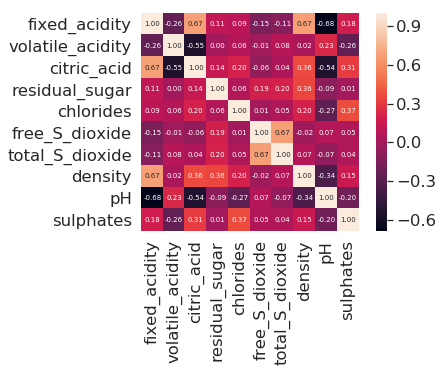

In [7]:
cols=['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_S_dioxide','total_S_dioxide','density','pH','sulphates']
cm=np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm=sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':7},yticklabels=cols,xticklabels=cols)
plt.show()

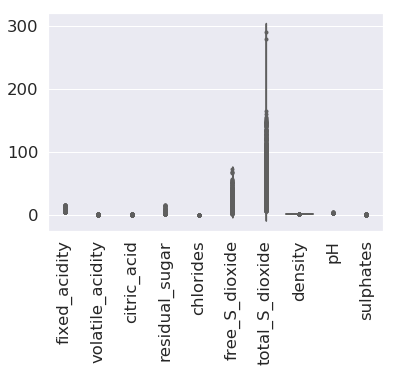

In [8]:
sns.violinplot(data=df[cols],palette='Set3',inner='points')
plt.xticks(rotation=90)
plt.show()

Violinplot is a nice tool to see the outliers. As one can see the total_S_dioxide feature may have two outliers (values over 200).

Spliting data into train and test datasets.

In [9]:
X=df[cols]
y=df['quality']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(1119, 10)
(480, 10)
(480,)
(1119,)


<a id='section2'>Section 2</a>

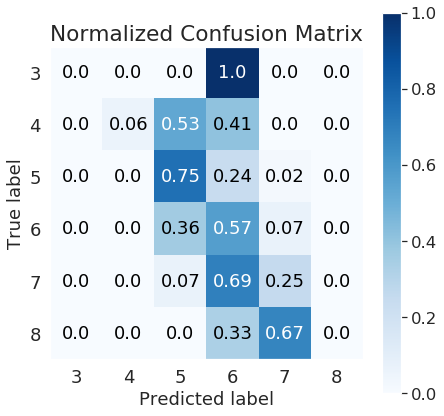

linear regresion accuracy score: 0.579
Best parameters:
{'clf1__C': 10, 'clf1__solver': 'newton-cg'}


In [10]:
clf1=LogisticRegression(penalty='l2',multi_class='auto', random_state=1,max_iter=250)
pipe1=Pipeline([('scl', StandardScaler()),
               ('clf1', clf1)])
    
parameters1={'clf1__C': [0.001, 0.1, 1, 10, 100],
            'clf1__solver': ['newton-cg', 'lbfgs']}
gs1=GridSearchCV(estimator=pipe1, param_grid=parameters1, scoring='accuracy', cv=9, iid=True)
gs1=gs1.fit(X_train, y_train)
y_pred_clf1 = gs1.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf1,normalize=True, figsize=(7,7))
plt.show()
print('linear regresion accuracy score: %.3f' %gs1.best_score_)
print('Best parameters:')
print(gs1.best_params_)

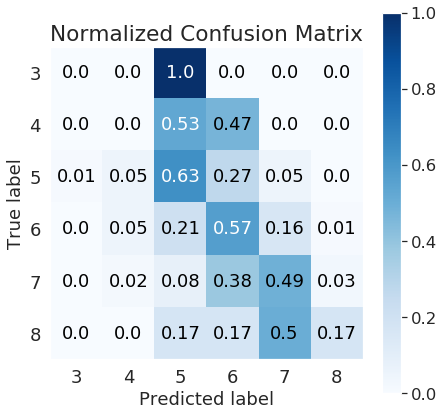

decision tree classifier accuracy: 0.599
Best parameters:
{'max_depth': None}


In [11]:
clf2=DecisionTreeClassifier(criterion='entropy', random_state=0)
gs2=GridSearchCV(estimator=clf2, param_grid=[
        {'max_depth':[1,2,3,4,5,6,7,8,None]}], scoring='accuracy',cv=9,iid=True)
gs2=gs2.fit(X_train, y_train)
y_pred_clf2 = gs2.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf2,normalize=True, figsize=(7,7))
plt.show()
print('decision tree classifier accuracy: %.3f' %gs2.best_score_)
print('Best parameters:')
print(gs2.best_params_)

KNeighbors calssifier

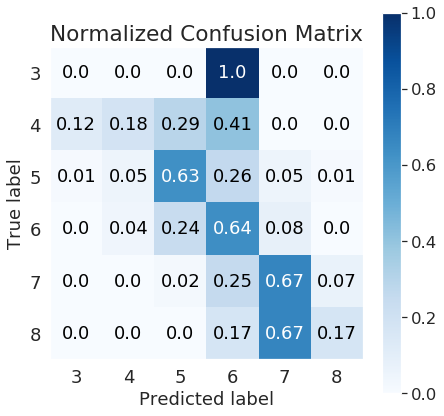

KNeighbors classifier accuracy: 0.587
Best parameters:
{'clf3__leaf_size': 1, 'clf3__n_neighbors': 1}


In [12]:
clf3=KNeighborsClassifier(algorithm='auto')
pipe3=Pipeline([('scl', StandardScaler()),
                ('clf3', clf3)])
parameters3={'clf3__n_neighbors':[1,2,3,4,5,6,7,8,9,10],
             'clf3__leaf_size':[1,5,10]}
gs3=GridSearchCV(estimator=pipe3, param_grid=parameters3, scoring='accuracy', cv=9, iid=True)
gs3=gs3.fit(X_train, y_train)
y_pred_clf3 = gs3.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf3,normalize=True, figsize=(7,7))
plt.show()
print('KNeighbors classifier accuracy: %.3f'%gs3.best_score_)
print('Best parameters:')
print(gs3.best_params_)

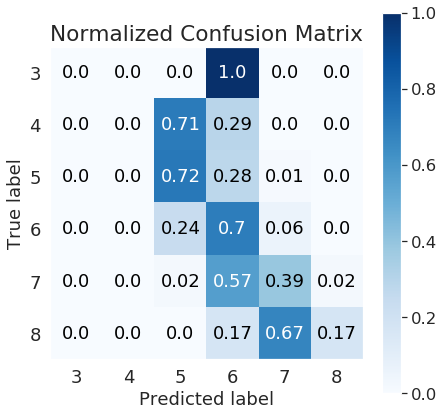

Random forest classifier accuracy: 0.635
Features importances:
fixed_acidity: 0.080
volatile_acidity: 0.125
citric_acid: 0.087
residual_sugar: 0.084
chlorides: 0.089
free_S_dioxide: 0.069
total_S_dioxide: 0.120
density: 0.124
pH: 0.080
sulphates: 0.144


In [13]:
clf4=RandomForestClassifier(n_estimators=100, criterion='entropy')
clf4.fit(X_train, y_train)
y_pred_clf4 = clf4.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf4,normalize=True, figsize=(7,7))
plt.show()
#print(clf4.feature_importances_)
print('Random forest classifier accuracy: %.3f' %clf4.score(X_test,y_test))
print('Features importances:')
for i, item in enumerate(clf4.feature_importances_): 
    print(cols[i]+': %.3f' %item)

Majority voiting classifier

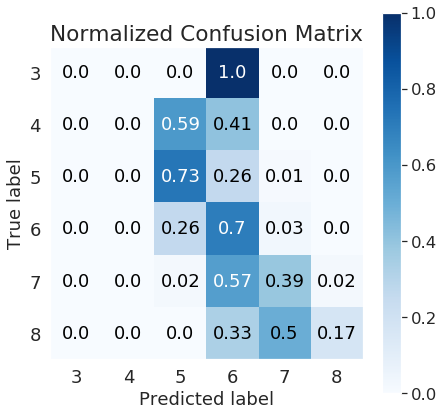

Voiting classifier accuracy: 0.642


In [14]:
mv_clf=VotingClassifier(estimators=[('dt',gs2), ('kn', gs3), ('rf', clf4)], voting='hard', weights=[1,1,3])
mv_clf.fit(X_train, y_train)
y_pred_mv_clf = mv_clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_mv_clf,normalize=True, figsize=(7,7))
plt.show()
print('Voiting classifier accuracy: %.3f' %mv_clf.score(X_test,y_test))

<a id='section3'>Section 3</a>

Because is going to be a lot writing the same code, I packed everything in functions ;)

In [15]:
def logistic_regresion_classifier(X_train, y_train, X_test, y_test, cv):
    clf=LogisticRegression(penalty='l2',multi_class='auto', random_state=1,max_iter=250)
    pipe=Pipeline([('scl', StandardScaler()),
               ('clf', clf)])
    
    parameters={'clf__C': [0.001, 0.1, 1, 10, 100],
            'clf__solver': ['newton-cg', 'lbfgs']}
    gs=GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy', cv=cv, iid=True)
    gs=gs.fit(X_train, y_train)
    y_pred_clf = gs.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf,normalize=True, figsize=(7,7))
    plt.show()
    print('linear regresion accuracy score: %.3f' %gs.best_score_)
    

In [16]:
def decision_tree_classifier(X_train, y_train, X_test, y_test, cv):
    clf=DecisionTreeClassifier(criterion='entropy', random_state=0)
    gs=GridSearchCV(estimator=clf, param_grid=[
        {'max_depth':[1,2,3,4,5,6,7,8,None]}], scoring='accuracy',cv=cv,iid=True)
    gs=gs.fit(X_train, y_train)
    y_pred_clf = gs.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf,normalize=True, figsize=(7,7))
    plt.show()
    print('decision tree classifier accuracy: %.3f' %gs.best_score_)
    return clf

In [17]:
def KNeighbors_classifier(X_train, y_train, X_test, y_test,cv):
    clf=KNeighborsClassifier(algorithm='auto')
    pipe=Pipeline([('scl', StandardScaler()),
                ('clf', clf)])
    parameters={'clf__n_neighbors':[1,2,3,4,5,6,7,8,9,10],
             'clf__leaf_size':[1,5,10]}
    gs=GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy', cv=cv, iid=True)
    gs=gs.fit(X_train, y_train)
    y_pred_clf = gs.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf,normalize=True, figsize=(7,7))
    plt.show()
    print('KNeighbors classifier accuracy: %.3f'%gs.best_score_)
    return gs

In [18]:
def Random_forest_classifier(X_train, y_train, X_test, y_test):
    clf=RandomForestClassifier(n_estimators=300, criterion='entropy')
    clf.fit(X_train, y_train)
    print('Random forest classifier accuracy: %.3f' %clf.score(X_test,y_test))
    y_pred_clf = clf.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf,normalize=True, figsize=(7,7))
    plt.show()
    return clf

The same code for data with the biggest features importance’s pointed from random forest classifier.

In [19]:
cols=['chlorides','total_S_dioxide','sulphates','alcohol']
X1=df[cols]
y1=df['quality']

X_train1, X_test1, y_train1, y_test1=train_test_split(X1,y1,test_size=0.3, random_state=42)

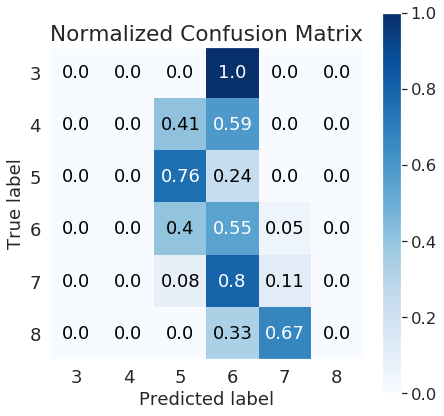

linear regresion accuracy score: 0.589


In [20]:
logistic_regresion_classifier(X_train1, y_train1, X_test1, y_test1, 9)

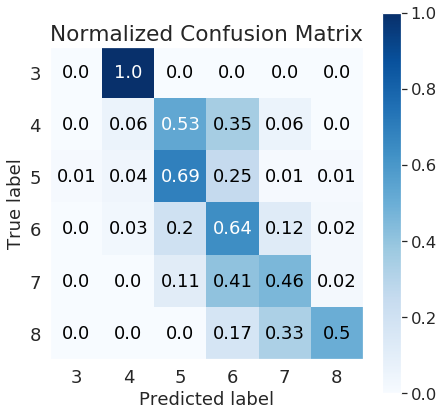

decision tree classifier accuracy: 0.603


In [21]:
gs21=decision_tree_classifier(X_train1, y_train1, X_test1, y_test1, 9)

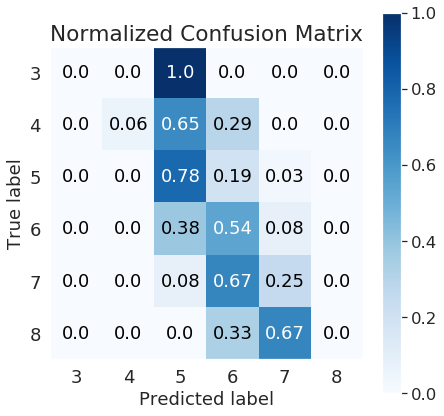

KNeighbors classifier accuracy: 0.619


In [22]:
gs31=KNeighbors_classifier(X_train1, y_train1, X_test1, y_test1, 9)

Random forest classifier accuracy: 0.658


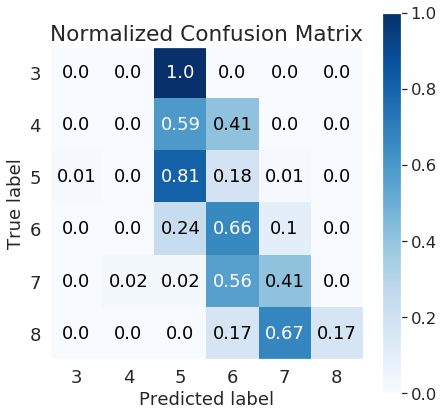

In [23]:
clf41=Random_forest_classifier(X_train1, y_train1, X_test1, y_test1)

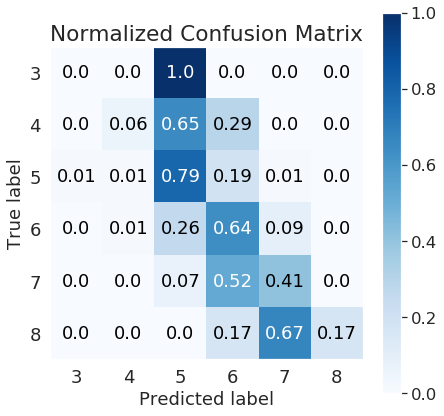

voting classifier accuracy: 0.646


In [24]:
mv_clf1=VotingClassifier(estimators=[('dt1',gs21), ('kn1', gs31), ('rf1', clf41)], voting='hard')
mv_clf1.fit(X_train1, y_train1)
y_pred_mv_clf1 = mv_clf1.predict(X_test1)
skplt.metrics.plot_confusion_matrix(y_test1, y_pred_mv_clf1,normalize=True, figsize=(7,7))
plt.show()
print('voting classifier accuracy: %.3f' %mv_clf1.score(X_test1,y_test1))

<a id='section4'>Section 4</a>

Removing outliers

In [25]:
newdf=df.drop(df[df['total_S_dioxide']>200].index)

In [26]:
nX=newdf[cols]
ny=newdf['quality']

nX_train, nX_test, ny_train, ny_test=train_test_split(nX,ny,test_size=0.3, random_state=42)

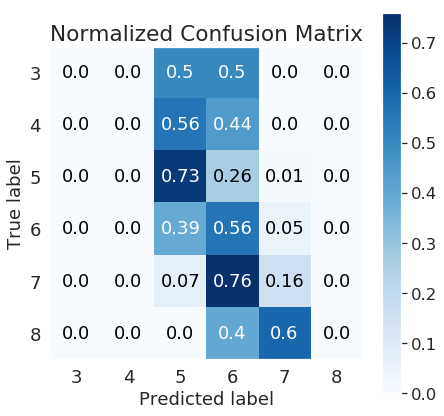

linear regresion accuracy score: 0.595


In [27]:
logistic_regresion_classifier(nX_train, ny_train, nX_test, ny_test, 8)

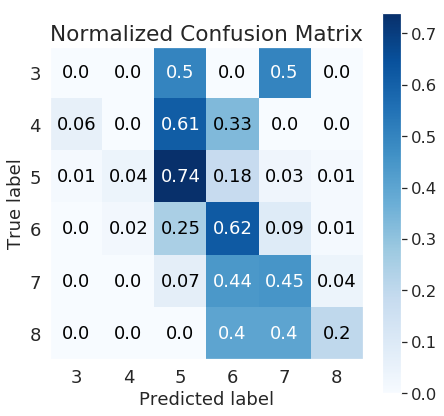

decision tree classifier accuracy: 0.594


In [28]:
ngs2=decision_tree_classifier(nX_train, ny_train, nX_test, ny_test, 8)

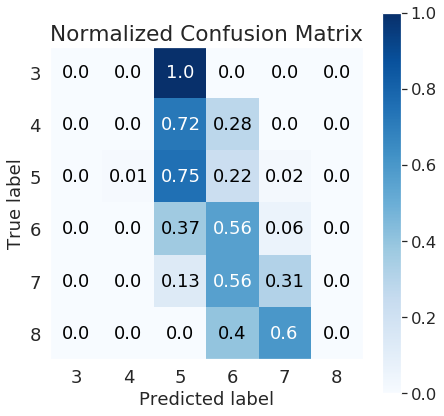

KNeighbors classifier accuracy: 0.598


In [29]:
ngs3=KNeighbors_classifier(nX_train, ny_train, nX_test, ny_test, 8)

Random forest classifier accuracy: 0.658


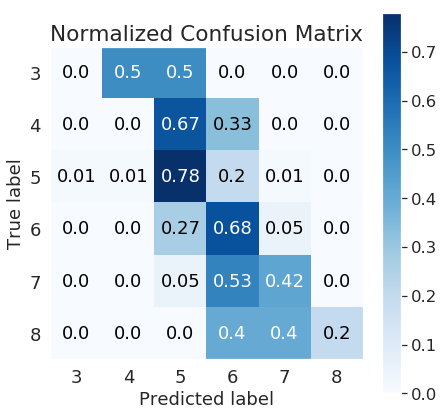

In [30]:
nclf4=Random_forest_classifier(nX_train, ny_train, nX_test, ny_test)

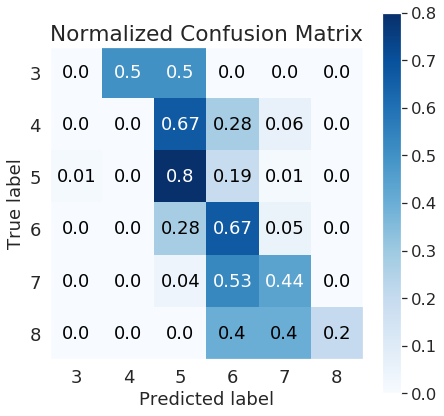

Voiting classifier accuracy: 0.662


In [31]:
nmv_clf=VotingClassifier(estimators=[('ndt',ngs2), ('nkn', ngs3), ('nrf', nclf4)], voting='hard', weights=[1,1,3])
nmv_clf.fit(nX_train, ny_train)
ny_pred_mv_clf = nmv_clf.predict(nX_test)
skplt.metrics.plot_confusion_matrix(ny_test, ny_pred_mv_clf,normalize=True, figsize=(7,7))
plt.show()
print('Voiting classifier accuracy: %.3f' %nmv_clf.score(nX_test,ny_test))

<a id='section5'>Section 5</a>

Making analysis only for data with wine qualiy equal 5,6,and 7. 

In [32]:
dat=df.drop(df[df['quality']<5].index)
data=dat.drop(dat[dat['quality']>7].index)
data['quality'].value_counts()

5    681
6    638
7    199
Name: quality, dtype: int64

In [33]:
newX=data[cols]
newy=data['quality']

newX_train, newX_test, newy_train, newy_test=train_test_split(newX,newy,test_size=0.3, random_state=42)

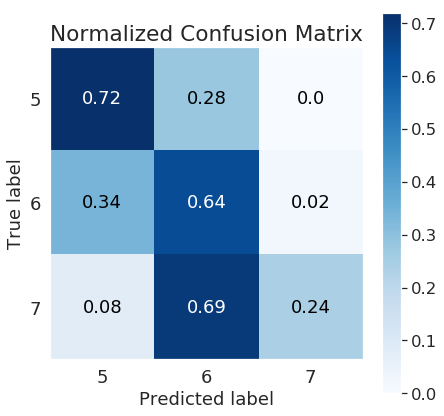

linear regresion accuracy score: 0.609


In [34]:
logistic_regresion_classifier(newX_train, newy_train, newX_test, newy_test, 8)

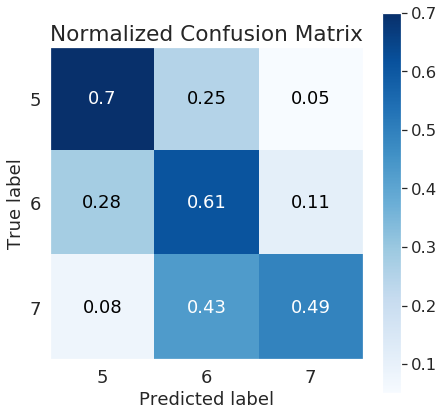

decision tree classifier accuracy: 0.645


In [35]:
newgs2=decision_tree_classifier(newX_train, newy_train, newX_test, newy_test, 8)

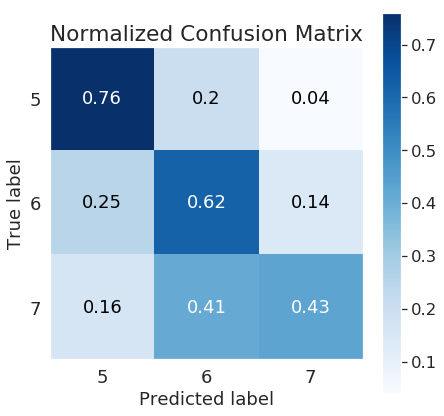

KNeighbors classifier accuracy: 0.650


In [36]:
newgs3=KNeighbors_classifier(newX_train, newy_train, newX_test, newy_test, 8)

Random forest classifier accuracy: 0.693


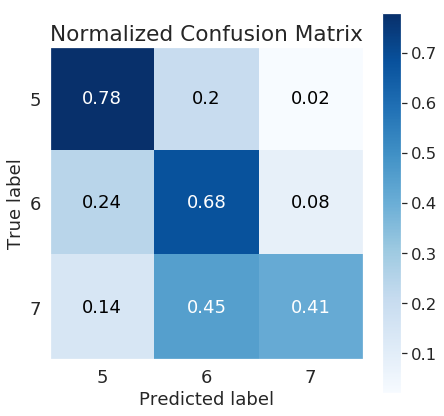

In [37]:
newclf4=Random_forest_classifier(newX_train, newy_train, newX_test, newy_test)

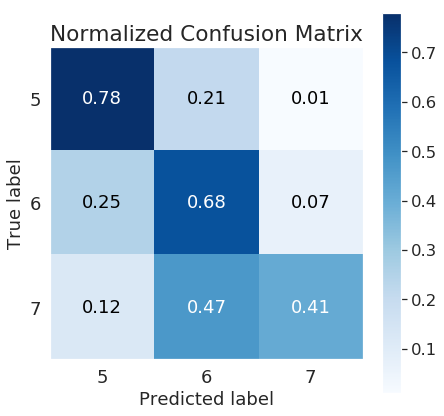

Voiting classifier accuracy: 0.693


In [38]:
newmv_clf=VotingClassifier(estimators=[('newdt',newgs2), ('newkn', newgs3), ('newrf', newclf4)], voting='hard', weights=[1,1,3])
newmv_clf.fit(newX_train, newy_train)
newy_pred_mv_clf = newmv_clf.predict(newX_test)
skplt.metrics.plot_confusion_matrix(newy_test, newy_pred_mv_clf,normalize=True, figsize=(7,7))
plt.show()
print('Voiting classifier accuracy: %.3f' %newmv_clf.score(newX_test,newy_test))

**Conclusions**

The samples of wine quality of 3, 4 and 8 have very poor predictions. However the best results gives Random forest classifier. When I treet samples of wine quality with values 3, 4 and 8 as a outliers the classifiers accuracy increases and the best result gives voting classiefier.